In [12]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak

import sys
sys.path.append("../..")
from hists.parameters import synchrotronBeamEnergiesMap
from hists.dataframe import DataframeComputations
from utils import makeDashLink, makeCsvRow, printCsvRowsFromDf

In [2]:
tree = uproot.open('/data_cms_upgrade/cuisset/testbeam18/clue3d/v31/cmssw/data/CLUE_clusters.root:clusters')

In [3]:
comp_test = DataframeComputations(tree.arrays(entry_stop=1000))  #.set_index(["event", "clus3D_id", "clus2D_id"])

In [4]:
def filterSpanEnergy(df:pd.DataFrame, minLayerSpan=5, minFractionOfBeamEnergy=0.2) -> pd.DataFrame:
    """ Filter 3D clusters to keep :
     - min layer span of 3D clusters
     - min fraction of beam energy of 3D clusters (incl synchrotron losses) 
    Then keep only the two highest energy 3D cluster per event (dropping events where only one 3D cluster passes selections)
    Returns dataframe with clus2D_minLayer	clus2D_maxLayer	beamEnergy	clus3D_energy	clus3D_size	clus3D_layerSpan
    Parameter : df : a dataframe holding beamEnergy, clus3D_energy, clus2D_minLayer, clus2D_maxLayer
    """
    return (df
    .eval("clus3D_layerSpan = clus2D_maxLayer - clus2D_minLayer")
    .query("clus3D_layerSpan >= @minLayerSpan")
    .sort_values(["event","clus3D_energy"])
    .groupby(["eventInternal"]).tail(2) # take the two trackster with max energy in each event
    # Filter events where only one trackster passes selections + filter on beam energy fraction
    .groupby("eventInternal").filter(lambda x : (len(x)>1 and x.clus3D_energy.min() > minFractionOfBeamEnergy*synchrotronBeamEnergiesMap[x.beamEnergy.iloc[0]]))
    .sort_values(["eventInternal", "clus2D_minLayer"])
    )

In [5]:
def unstackDataframe(df:pd.DataFrame):
    """ Unstack the 3D clusters into columns
    Retuyrns a dataframe with multiindex columns, where second layer is 
     - 0 for trackster with smallest first layer
     - 1 for the other trackster
    """
    df_unstacked = (df.assign(clus3D_number=df.groupby("eventInternal").cumcount())
        .reset_index("clus3D_id")
        .set_index("clus3D_number", append=True)
        .unstack()
    )
    #new_df = df_unstacked[["clus3D_id", "clus3D_energy", "clus2D_minLayer", "clus2D_maxLayer", "clus3D_layerSpan"]]
    return df_unstacked

In [6]:
def splitTracksterSelections(df:pd.DataFrame, maxLayerOverlap=2):
    """ Select events where the two tracksters overlap for at most maxLayerOverlap layers """
    return df.loc[df.clus2D_maxLayer[0] - df.clus2D_minLayer[1] < maxLayerOverlap]

In [10]:
def findSplitTracksters(minLayerSpan=5, minFractionOfBeamEnergy=0.2, maxLayerOverlap=2):
    """ """
    selected_df = []
    total_events = 0
    for array in tree.iterate(step_size="10MB", library="ak", #entry_stop=10000,
            filter_name=["event", "ntupleNumber", "beamEnergy", "clus3D_energy", "clus3D_size", "clus3D_idxs", "clus2D_layer"], 
            ):
        total_events += len(array)
        comp = DataframeComputations(array)
        selected_df.append(comp
            .clusters3D_merged_2D_custom(comp.clusters3D_with_clus2D_id(["ntupleNumber", "event"]), comp.clusters2D_custom(["clus2D_layer"]))
            .pipe(comp.clusters3D_firstLastLayer, columnsToKeep=["beamEnergy", "ntupleNumber", "event", "clus3D_energy"])

            .pipe(filterSpanEnergy, minLayerSpan=minLayerSpan, minFractionOfBeamEnergy=minFractionOfBeamEnergy)
            .pipe(unstackDataframe)
            .pipe(splitTracksterSelections, maxLayerOverlap=maxLayerOverlap)
        )
    return pd.concat(selected_df), total_events

def printSplitTracksters(df:pd.DataFrame):
    new_df = df[["beamEnergy", "ntupleNumber", "event"]].loc[:, (slice(None),0)]
    new_df.columns = new_df.columns.droplevel(1) # remove the extra multiindex column level
    printCsvRowsFromDf(new_df, source="SplitTrackster")

In [8]:
splitTrackster_df, total_events = findSplitTracksters(minLayerSpan=3)
print(f"{len(splitTrackster_df.index)/total_events:%}")

0.444526%


In [13]:
printSplitTracksters(splitTrackster_df)

300;435;2015;;SplitTrackster
300;435;5559;;SplitTrackster
300;435;8222;;SplitTrackster
300;435;8406;;SplitTrackster
300;435;1049;;SplitTrackster
300;435;347;;SplitTrackster
20;436;2610;;SplitTrackster
20;436;575;;SplitTrackster
20;436;1986;;SplitTrackster
20;437;5241;;SplitTrackster
20;437;6790;;SplitTrackster
20;437;7039;;SplitTrackster
20;437;9880;;SplitTrackster
20;437;3024;;SplitTrackster
20;437;3092;;SplitTrackster
20;437;3572;;SplitTrackster
20;437;4589;;SplitTrackster
20;437;136;;SplitTrackster
20;437;478;;SplitTrackster
20;437;780;;SplitTrackster
20;437;1829;;SplitTrackster
20;437;1956;;SplitTrackster
20;437;2322;;SplitTrackster
20;439;4876;;SplitTrackster
20;439;5026;;SplitTrackster
20;439;5442;;SplitTrackster
20;439;6183;;SplitTrackster
20;439;6378;;SplitTrackster
20;439;6588;;SplitTrackster
20;439;4153;;SplitTrackster
20;439;4259;;SplitTrackster
20;439;4525;;SplitTrackster
20;439;4867;;SplitTrackster
20;439;7798;;SplitTrackster
20;439;8654;;SplitTrackster
20;439;8966;;SplitT

In [ ]:
pd.options.display.min_rows=100
splitTrackster_df

,beamEnergy,ntupleNumber,event
eventInternal,,,
661,300.0,435,2015
2469,300.0,435,5559
2726,300.0,435,8222
3002,300.0,435,8406
3506,300.0,435,1049
3917,300.0,435,347
4032,20.0,436,2610
4178,20.0,436,575
4419,20.0,436,1986


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

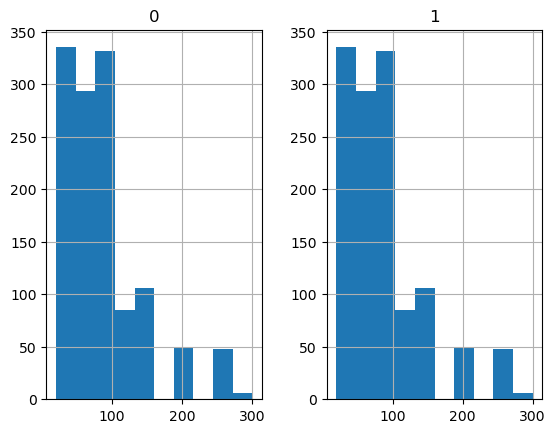

In [ ]:
splitTrackster_df.beamEnergy.hist()